<a href="https://colab.research.google.com/github/davione112/HateSpeechDetection/blob/main/Hate_speech_detection_Bi_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np 
import os
import re
import pickle
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Bidirectional, LSTM, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, Embedding, Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [3]:
os.chdir('/content/drive/MyDrive/hate_speech_detection/')

In [4]:
train = pd.read_excel("preprocessed_data/train.xlsx")
dev= pd.read_excel("preprocessed_data/dev.xlsx")
test= pd.read_excel("preprocessed_data/test.xlsx")

##Bi-GRU

##PhoW2V

###Load word embedding

In [ ]:
EMBEDDING_FILE = 'embedding/word2vec_vi_words_300dims.txt'
MODEL_FILE = 'save_model/Bi_GRU_model_PhoW2V.h5'
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

###model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     3993300     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 100, 600)     1083600     spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

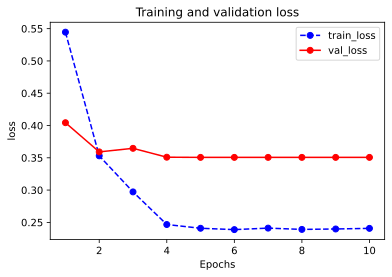

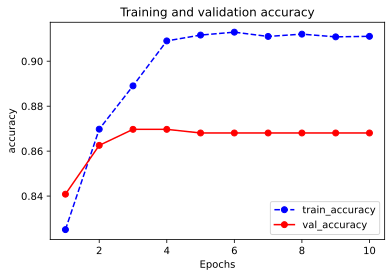

In [ ]:
X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values 

X_train = X_train.fillna('NaN')
X_dev = X_dev.fillna('NaN')
X_test = X_test.fillna('NaN')

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 14000 
sequence_length = 100
embedding_dim = 300
batch_size = 256
epochs = 10
learning_rate = 5e-4
decay_rate = learning_rate / epochs

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

def scheduler(epoch, lr):
    if epoch < 3:
        print(lr)
        return float(lr)
    else:
        return float(lr * tf.math.exp(-3.))

X_train, y_train = make_featues(X_train, y_train, tokenizer)
X_dev, y_dev, = make_featues(X_dev, y_dev, tokenizer)
X_test, y_test, = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)

# --------------MODEL-------------------------
tf.random.set_seed(1)

input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
tf.random.set_seed(1)
x= SpatialDropout1D(0.4)(x)
tf.random.set_seed(1)
x = Bidirectional(GRU(300, return_sequences=True))(x)
tf.random.set_seed(1)
x = Bidirectional(GRU(150, return_sequences=True))(x)
tf.random.set_seed(1)
x = Bidirectional(GRU(50, return_sequences=True))(x)
tf.random.set_seed(1)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
tf.random.set_seed(1)
output = Dense(3, activation="softmax")(conc)
model = Model(inputs=input, outputs=output)
model.summary()

adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
tf.random.set_seed(1)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1) ,       
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
tf.random.set_seed(1)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev, y_dev),callbacks=my_callbacks,shuffle=False)  
model.save(MODEL_FILE)
prediction = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred = prediction.argmax(axis=-1)
cf = confusion_matrix(y_test, y_pred)
print(cf)
print(classification_report(y_pred, y_test, digits = 4))
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

##FastText

###Load word embedding

In [5]:

EMBEDDING_FILE = 'embedding/cc.vi.300.vec'
MODEL_FILE = 'save_model/Bi_GRU_model_FasText.h5'
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

###Model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 300)     3993300     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 100, 300)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 100, 300)     406800      spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

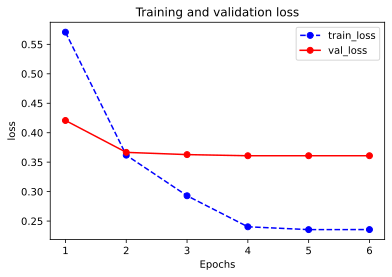

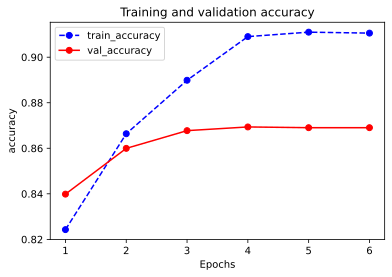

In [11]:
X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values
from tensorflow.keras.utils import to_categorical
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)
    return X, y
seed = 1
vocabulary_size = 14000 
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 10
learning_rate = 5e-4
decay_rate = learning_rate / epochs


X_train = X_train.fillna('NaN')
X_dev = X_dev.fillna('NaN')
X_test = X_test.fillna('NaN')
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# --------------LOAD WORD EMBEDDING-------------------------
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))


def scheduler(epoch, lr):
    if epoch < 3:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-3.))
for word, i in word_index.items():
    if i >= vocabulary_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
tf.random.set_seed(seed)
X_train, y_train = make_featues(X_train, y_train, tokenizer)
X_dev, y_dev, = make_featues(X_dev, y_dev, tokenizer)
X_test, y_test, = make_featues(X_test, y_test, tokenizer, is_one_hot_label=False)
tf.random.set_seed(seed)
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
tf.random.set_seed(seed)
x= SpatialDropout1D(0.2)(x)
tf.random.set_seed(seed)
x = Bidirectional(GRU(150, return_sequences=True))(x)
tf.random.set_seed(seed)
x = Bidirectional(GRU(50, return_sequences=True))(x)
tf.random.set_seed(seed)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
tf.random.set_seed(seed)
output = Dense(3, activation="softmax")(conc)
model = Model(inputs=input, outputs=output)
tf.random.set_seed(seed)
model.summary()
tf.random.set_seed(seed)
adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)
tf.random.set_seed(seed)
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1) ,       
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
tf.random.set_seed(seed)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
tf.random.set_seed(seed)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev, y_dev),callbacks=my_callbacks,shuffle=False)  
model.save(MODEL_FILE)

prediction = model.predict(X_test, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf = confusion_matrix(y_test, y_pred)
print(cf)

df_cm = pd.DataFrame(cf, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 28})
print(classification_report(y_pred, y_test, digits = 4))
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(history, 'loss')
plot_metric(history, 'accuracy')